<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [103]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [104]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [106]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [107]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


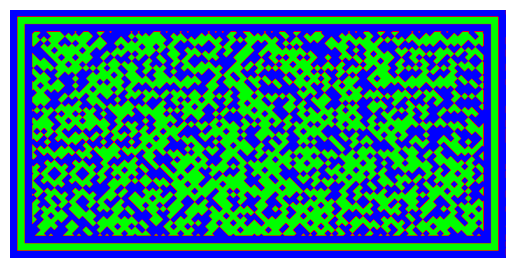

In [108]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [109]:
###     YOUR CODE FOR TASK 1    ###
### ADD MORE CELLS IF NECESSARY ###

In [110]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    yb = torch.argmax(yb, dim=1)  # Convert target tensor to 1-dimensional tensor

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())  # Use long() to convert targets to class indices

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data.long())  # Use long() for target comparison

    return loss.item(), corrects, len(xb)


In [111]:
from tqdm import tqdm
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for epoch in tqdm(range(epochs)):


        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:

            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb,opt)

            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num


        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:

                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)

                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num


        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')

In [112]:
from torch.utils.data import DataLoader
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [113]:
bs=16
train_dl, valid_dl = get_data(train_dataset, val_dataset, bs)

In [114]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [115]:
# model = nn.Sequential(
#     nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(64, 10, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.AvgPool2d(4),
#     Lambda(lambda x: x.view(x.size(0), -1)),
#     nn.Linear(60, 10),
# )
model = nn.Sequential(
    # nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    # nn.BatchNorm2d(32),
    # nn.ReLU(),
    # nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    # nn.BatchNorm2d(64),
    # nn.ReLU(),
    # nn.Conv2d(64, 10, kernel_size=3, stride=1, padding=1),
    # nn.BatchNorm2d(10),
    # nn.ReLU(),
    # nn.AvgPool2d(4),
    # Lambda(lambda x: x.view(x.size(0), -1)),
    # nn.Linear(3600, 10),
    
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4,
                    reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32, 64, kernel_size=4, stride=3),
    nn.ReLU(inplace=True),

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=4, stride=1, rotation=4,
                    reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),

    Lambda(lambda x: x.view(x.size(0), -1)),

    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    
)


# model = nn.Sequential(
#     nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(32),
#     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(64),
#     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(128),
#     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(256),
#     nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(512),
#     nn.AdaptiveAvgPool2d(1),
#     Lambda(lambda x: x.view(x.size(0), -1)),
#     nn.Linear(512, 10)
# )


In [116]:
from torch import optim

lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=20
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  5%|▌         | 1/20 [00:11<03:40, 11.63s/it]

EPOCH: 01/20 LOSS: 1.2186 ACC: 0.4171  VAL-LOSS: 0.9683 VAL-ACC: 0.5505 


 10%|█         | 2/20 [00:22<03:23, 11.32s/it]

EPOCH: 02/20 LOSS: 0.4525 ACC: 0.8184  VAL-LOSS: 0.3168 VAL-ACC: 0.8765 


 15%|█▌        | 3/20 [00:33<03:08, 11.08s/it]

EPOCH: 03/20 LOSS: 0.1567 ACC: 0.9435  VAL-LOSS: 0.1319 VAL-ACC: 0.9505 


 20%|██        | 4/20 [00:44<02:53, 10.85s/it]

EPOCH: 04/20 LOSS: 0.1056 ACC: 0.9665  VAL-LOSS: 0.1273 VAL-ACC: 0.9600 


 25%|██▌       | 5/20 [00:56<02:50, 11.33s/it]

EPOCH: 05/20 LOSS: 0.0901 ACC: 0.9709  VAL-LOSS: 0.0759 VAL-ACC: 0.9735 


 30%|███       | 6/20 [01:07<02:40, 11.48s/it]

EPOCH: 06/20 LOSS: 0.0474 ACC: 0.9843  VAL-LOSS: 0.0674 VAL-ACC: 0.9780 


 35%|███▌      | 7/20 [01:18<02:27, 11.31s/it]

EPOCH: 07/20 LOSS: 0.0652 ACC: 0.9781  VAL-LOSS: 0.9701 VAL-ACC: 0.9760 


 40%|████      | 8/20 [01:30<02:14, 11.24s/it]

EPOCH: 08/20 LOSS: 0.0480 ACC: 0.9852  VAL-LOSS: 0.0769 VAL-ACC: 0.9805 


 45%|████▌     | 9/20 [01:41<02:03, 11.21s/it]

EPOCH: 09/20 LOSS: 0.0321 ACC: 0.9899  VAL-LOSS: 0.0766 VAL-ACC: 0.9780 


 50%|█████     | 10/20 [01:52<01:51, 11.18s/it]

EPOCH: 10/20 LOSS: 0.0377 ACC: 0.9869  VAL-LOSS: 0.0448 VAL-ACC: 0.9855 


 55%|█████▌    | 11/20 [02:03<01:41, 11.31s/it]

EPOCH: 11/20 LOSS: 0.0447 ACC: 0.9861  VAL-LOSS: 0.0430 VAL-ACC: 0.9925 


 60%|██████    | 12/20 [02:17<01:35, 11.89s/it]

EPOCH: 12/20 LOSS: 0.0301 ACC: 0.9896  VAL-LOSS: 0.0720 VAL-ACC: 0.9810 


 65%|██████▌   | 13/20 [02:30<01:25, 12.20s/it]

EPOCH: 13/20 LOSS: 0.0324 ACC: 0.9891  VAL-LOSS: 0.0768 VAL-ACC: 0.9830 


 70%|███████   | 14/20 [02:43<01:15, 12.65s/it]

EPOCH: 14/20 LOSS: 0.0356 ACC: 0.9892  VAL-LOSS: 0.0225 VAL-ACC: 0.9915 


 75%|███████▌  | 15/20 [02:56<01:02, 12.60s/it]

EPOCH: 15/20 LOSS: 0.0119 ACC: 0.9956  VAL-LOSS: 0.0299 VAL-ACC: 0.9900 


 80%|████████  | 16/20 [03:07<00:49, 12.35s/it]

EPOCH: 16/20 LOSS: 0.0406 ACC: 0.9883  VAL-LOSS: 0.1200 VAL-ACC: 0.9650 


 85%|████████▌ | 17/20 [03:19<00:36, 12.13s/it]

EPOCH: 17/20 LOSS: 0.0514 ACC: 0.9856  VAL-LOSS: 0.0396 VAL-ACC: 0.9885 


 90%|█████████ | 18/20 [03:30<00:23, 11.85s/it]

EPOCH: 18/20 LOSS: 0.0388 ACC: 0.9891  VAL-LOSS: 0.1771 VAL-ACC: 0.9630 


 95%|█████████▌| 19/20 [03:42<00:11, 11.67s/it]

EPOCH: 19/20 LOSS: 0.0296 ACC: 0.9911  VAL-LOSS: 0.1844 VAL-ACC: 0.9740 


100%|██████████| 20/20 [03:53<00:00, 11.66s/it]

EPOCH: 20/20 LOSS: 0.0230 ACC: 0.9921  VAL-LOSS: 0.0649 VAL-ACC: 0.9815 


In [117]:

# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')

# def evaluate(model, loss_func, data_loader):
#         model.eval()
#         with torch.no_grad():
#             running_loss = 0.0
#             running_corrects = 0
#             sample_num=0
#             for xb, yb in valid_dl:

#                 # forward
#                 losses, corrects, nums = loss_batch(model, loss_func, xb, yb)

#                 # statistics
#                 running_loss += losses * xb.size(0)
#                 running_corrects += corrects
#                 sample_num+=nums

#             test_loss = running_loss / sample_num
#             test_acc = running_corrects.double()/ sample_num



In [118]:
# # Evaluate the model on the test set
# test_loss, test_accuracy = evaluate(model, loss_func, test_dataset)


## Task 1: Question 5d

# Task 2: Carpet Matching 

In [119]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [120]:
# # function to determine performance of model
# def query_performance(queries, targets, gt, top=1):
#     assert top >= 1
#     cnt = 0
#     for i in range(gt.shape[0]):
#
#         q = queries[i][None].float().cuda()
#         t = targets[i].float().cuda()
#
#         with torch.no_grad():
#
#
#             ### MODIFY IF NECESSARY ###
#             emb_q = net(q).cpu().numpy()
#             emb_t = net(t).cpu().numpy()
#
#             dists = cdist(emb_q, emb_t)
#
#             if top == 1:
#                 pred = np.argmin(dists)
#
#                 if pred == gt[i]:
#                     cnt += 1
#
#             else:
#                 pred = np.argsort(dists)
#                 if gt[i] in pred[0,:top].tolist():
#                     cnt+=1
#     return (100*cnt/gt.shape[0])

In [121]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###

In [122]:
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn

# Define your model for task 2
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define your model architecture here
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.avgpool = nn.AvgPool2d(4)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# Create an instance of the model
net = Model()

# Load the pre-trained weights (if available)
# net.load_state_dict(torch.load('task2_model_weights.pth'))

# Set the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries[i][None]).float().to(device)
        t = torch.from_numpy(targets[i]).float().to(device)

        with torch.no_grad():
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100 * cnt / gt.shape[0])

# Test the performance of the model
top_1_accuracy = query_performance(queries, targets, gt, top=1)
top_3_accuracy = query_performance(queries, targets, gt, top=3)

In [123]:
print(top_1_accuracy)
print(top_3_accuracy)

20.333333333333332
65.0


In [124]:
# import torch
# import torch.nn as nn
# import numpy as np
# from scipy.spatial.distance import cdist

# # Define the model architecture
# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
#         self.relu2 = nn.ReLU()
#         self.flatten = nn.Flatten()
#         self.linear = nn.Linear(164864, num_classes)  # Adjust the input size based on your data

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.flatten(x)
#         x = self.linear(x)
#         return x

# # Function to determine performance of the model
# def query_performance(queries, targets, gt, top=1):
#     assert top >= 1
#     cnt = 0
#     for i in range(gt.shape[0]):
#         q = queries[i][None].float().to(device)
#         t = targets[i].float().to(device)

#         with torch.no_grad():
#             emb_q = net(q)
#             emb_t = net(t)

#             dists = cdist(emb_q.cpu().numpy(), emb_t.cpu().numpy())

#             if top == 1:
#                 pred = np.argmin(dists)

#                 if pred == gt[i]:
#                     cnt += 1
#             else:
#                 pred = np.argsort(dists)
#                 if gt[i] in pred[0, :top].tolist():
#                     cnt += 1
#     return (100 * cnt / gt.shape[0])

# # Loading training and testing data for Task 2
# task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# X = task2['arr_0'].astype(float)
# y = task2['arr_1'].astype(int)
# gt = task2['arr_2'].astype(int)  # Ground truth
# queries = task2['arr_3'].astype(float)
# targets = task2['arr_4'].astype(float)

# # Determine the number of distinct classes in your dataset
# num_classes = len(np.unique(y))

# # Convert numpy arrays to PyTorch tensors
# X = torch.from_numpy(X).float().to(device)
# y = torch.from_numpy(y).long().to(device)
# gt = torch.from_numpy(gt).long().to(device)
# queries = torch.from_numpy(queries).float().to(device)
# targets = torch.from_numpy(targets).float().to(device)

# # Create an instance of the model
# net = Model().to(device)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# # Training loop
# num_epochs = 10
# batch_size = 32
# total_samples = X.shape[0]
# num_batches = total_samples // batch_size

# for epoch in range(num_epochs):
#     for batch_idx in range(num_batches):
#         start_idx = batch_idx * batch_size
#         end_idx = start_idx + batch_size

#         inputs = X[start_idx:end_idx]
#         labels = y[start_idx:end_idx]

#         optimizer.zero_grad()

#         # Forward pass
#         outputs = net(inputs)

#         # Compute loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#     # Print epoch loss
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# # Test the performance of the model
# top_1_accuracy = query_performance(queries, targets, gt, top=1)
# top_3_accuracy = query_performance(queries, targets, gt, top=3)

# print(f"Top-1 Accuracy: {top_1_accuracy}%")
# print(f"Top-3 Accuracy: {top_3_accuracy}%")
